In [1]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error
import scipy.io
from dataset_maker.dataset_maker import create_kfold_splits
from sklearn.model_selection import KFold, cross_val_score
from chemotools.scatter import StandardNormalVariate
mat_data = scipy.io.loadmat('./dataset/03/wheat_kernel.mat')
print(mat_data.keys())
Xtest, Xcal, ytest, ycal = mat_data['Xtest'], mat_data['Xcal'], mat_data['ytest'], mat_data['ycal']
print(Xcal.shape)

Configuration is valid.
NUM_FOLDS: 5
SHUFFLE_DATA: True
RANDOM_SEED: 42
CHEMICAL_SUBSTANCES: [5]
WINDOW_SIZE_START: 6
WINDOW_SIZE_END: 12
WINDOW_SIZE_STEP: 2
ALPHA_THRESHOLD: 0.05
PLS_COMPONENTS: 10
dict_keys(['__header__', '__version__', '__globals__', 'VarLabels_X', 'Xcal', 'ycal', 'Xtest', 'ytest'])
(415, 100)


In [2]:
X = np.concatenate((Xcal, Xtest))
y = np.concatenate((ycal, ytest))
fold, kf = create_kfold_splits(input_data=X, target=y, print_info=True)
import pandas as pd
from sklearn.model_selection import train_test_split

Fold 0:
  Train: index=[  1   3   4   5   7   8  12  13  14  16  17  19  20  21  23  24  25  26
  27  28  29  31  32  34  35  36  37  38  40  41  42  43  44  45  47  48
  49  50  51  52  53  54  56  57  58  59  60  61  62  64  65  66  67  69
  71  74  80  81  83  85  86  87  88  91  92  94  95  96  97  98  99 100
 102 103 105 106 107 108 109 110 111 112 113 114 115 116 118 119 120 121
 122 123 125 126 127 128 129 130 133 134 135 136 138 139 141 142 143 144
 145 146 147 149 150 151 152 154 156 157 159 160 161 162 163 164 165 166
 168 169 170 171 172 173 174 175 176 178 179 181 183 185 186 187 188 189
 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207
 208 211 212 213 214 215 216 217 219 220 221 222 223 224 226 227 229 230
 231 232 233 235 236 237 238 239 240 241 242 243 244 246 248 249 251 252
 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271
 272 273 274 275 276 278 279 282 283 284 285 287 288 289 292 293 294 295
 296 297 298 300 302 303 304

In [3]:
X_mean = np.mean(X, axis=0)
X_centered = X - X_mean
y_mean = np.mean(y)
y_centered = y - y_mean
X = X_centered
y = y_centered

In [4]:
def divide_index_part_into_window(spectra, N):
    """Divide spectra into N equal intervals."""
    interval_size = spectra.shape[1] // N
    intervals = [spectra[:, i * interval_size:(i + 1) * interval_size] for i in range(N)]
    return intervals
def divide_index_spectra_into_window(spectra, N):
    total_features = spectra.shape[1]
    interval_size = total_features // N
    remainder = total_features % N
    windows = [np.arange(i * interval_size, (i + 1) * interval_size) for i in range(N)]
    if remainder > 0:
        windows[-1] = np.arange((N - 1) * interval_size, total_features)
    return windows
def divide_data_into_parts(X, num_parts=5):
    part_size = X.shape[1] // num_parts
    parts = [np.arange(i * part_size, (i + 1) * part_size) for i in range(num_parts)]
    return parts

In [5]:
def weighted_binary_matrix(all_index_subsets, M, weight):
    keys = list(all_index_subsets.keys())
    n = len(keys)
    W = np.column_stack((weight, np.zeros((n, 200))))
    binary_matrix = np.zeros((M, n))
    for k in range(n):
        column = np.concatenate([np.ones(round(weight[k] * M)), 
                                np.zeros(M - round(weight[k] * M))])
        np.random.shuffle(column)  # shuffle the column like randperm
        binary_matrix[:, k] = column
    return binary_matrix

In [6]:
def compute_rmsecv_with_dropped_indices(binary_subset, X, y, kf, frozen_parts):
    """Compute RMSECV using Partial Least Squares and K-Fold cross-validation."""
    pls = PLSRegression(n_components=10)
    unique_indices = set()
    for key, value in binary_subset.items():
        unique_indices.update(value)
    unique_indices = np.array(sorted(unique_indices))
    frozen_parts = frozen_parts.astype(int)
    if len(unique_indices) == 0:
        scores = -cross_val_score(pls, X[:, frozen_parts], y, cv=kf, scoring='neg_mean_squared_error')
        rmsecv = np.sqrt(np.mean(scores))
        return rmsecv
    combined_indices = np.concatenate([frozen_parts, unique_indices])
    combined_indices = combined_indices.astype(int)
    scores = -cross_val_score(pls, X[:, combined_indices], y, cv=kf, scoring='neg_mean_squared_error')
    rmsecv = np.sqrt(np.mean(scores))
    return rmsecv

In [7]:
def update_sampling_weights(uninfo_indeces, binary_matrix, num_selected_model):
    weight = np.sum(binary_matrix[uninfo_indeces, :], axis=0) / num_selected_model
    return weight

In [8]:
def local_search_optimization(binary_subset, X, y, kf, frozen_parts, current_part_indices):
    """Optimize the width of each selected wavelength interval, ensuring it stays within the current part."""    
    optimized_subset = binary_subset.copy()  # Start with the initial intervals
    for key, interval in binary_subset.items():
        left_bound = current_part_indices[0]
        right_bound = current_part_indices[-1]
        optimized_interval = interval.copy()  # Copy the initial interval
        while optimized_interval[0] > left_bound:  # Ensure we don't go beyond the part's left bound
            new_interval = np.insert(optimized_interval, 0, optimized_interval[0] - 1)
            new_X_subset = np.concatenate([frozen_parts, X[:, new_interval]], axis=1) #############
            new_rmsecv = compute_rmsecv_with_dropped_indices(optimized_subset, X, y, kf, frozen_parts)
            if new_rmsecv < compute_rmsecv_with_dropped_indices(optimized_subset, X, y, kf, frozen_parts):
                optimized_interval = new_interval  # Accept if RMSECV decreases
                optimized_subset[key] = optimized_interval
            else:
                break  # Stop if no improvement
        while optimized_interval[-1] < right_bound:  # Ensure we don't go beyond the part's right bound
            new_interval = np.append(optimized_interval, optimized_interval[-1] + 1)
            new_X_subset = np.concatenate([frozen_parts, X[:, new_interval]], axis=1) ###############
            new_rmsecv = compute_rmsecv_with_dropped_indices(optimized_subset, X, y, kf, frozen_parts)
            if new_rmsecv < compute_rmsecv_with_dropped_indices(optimized_subset, X, y, kf, frozen_parts):
                optimized_interval = new_interval  # Accept if RMSECV decreases
                optimized_subset[key] = optimized_interval
            else:
                break  # Stop if no improvement
    return optimized_subset

In [9]:
def find_informative_features(X, y, kf, M=500, num_parts=5, intervals_per_part=10, alpha=0.1):
    previous_backup = False
    rmsecv_min = float('inf')
    backup_index_min = {}
    parts = divide_data_into_parts(X, num_parts)  # Step 1: Divide features into parts
    informative_parts = [None] * num_parts
    for part_idx, part_indices in enumerate(parts):
        previous_rmsecv_avg = float('inf')
        print(f"Optimizing part {part_idx + 1}/{num_parts}")
        frozen_parts = np.concatenate([informative_parts[i] if informative_parts[i] is not None else parts[i]
                            for i in range(num_parts) 
                            if i != part_idx and (informative_parts[i] is not None or i > part_idx)])
        windows = divide_index_part_into_window(parts[part_idx].reshape(1, len(parts[part_idx])), intervals_per_part)
        all_index_subsets = {(i, j): windows[j].flatten() for i in range(0, 1) for j in range(len(windows))}
        keys = list(all_index_subsets.keys())
        keys_flatten = np.arange(0, len(keys))
        key_and_flatten_dict = {}
        for i in range(len(keys)):
            key_and_flatten_dict[i] = keys[i]
        weight = np.ones(len(keys)) * 0.5  # Initial weights
        iteration = 0
        while True:
            binary_matrix = weighted_binary_matrix(all_index_subsets, M, weight)
            binary_samples = {}
            for i in range(M):
                binary_subset = {}
                selected_flatten_key = keys_flatten[binary_matrix[i] == 1]
                for j in range(len(selected_flatten_key)):
                    selected_interval = all_index_subsets[key_and_flatten_dict[selected_flatten_key[j]]]
                    binary_subset[keys[selected_flatten_key[j]]] = selected_interval
                binary_samples[i] = binary_subset
            rmsecvs = [compute_rmsecv_with_dropped_indices(binary_subset, X, y, kf, frozen_parts) for binary_subset in binary_samples.values()]
            sorted_indices = np.argsort(rmsecvs)[:int(alpha * M)]
            rmsecv_avg = np.mean([rmsecvs[i] for i in sorted_indices])
            print(f"Average RMSECV: {rmsecv_avg}")
            if rmsecv_avg >= previous_rmsecv_avg:
                print("Converged! RMSECV has increased.")
                break
            info_subsets = []
            info_subsets = [binary_samples[i] for i in sorted_indices]
            previous_rmsecv_avg = rmsecv_avg
            weight = update_sampling_weights(sorted_indices, binary_matrix, int(alpha * M))
            iteration += 1
            print(f'iteration: {iteration},        rmsecv_avg: {rmsecv_avg}')
        final_subset = info_subsets[np.argmin([rmsecvs[i] for i in sorted_indices])]
        if iteration == 0:
            final_subset = {}
        info_features = []
        for k, v in final_subset.items():
            info_features.append(list(v))
        informative_parts[part_idx] = np.array(info_features).flatten()
    print("Final informative parts identified.")
    return informative_parts, backup_index_min

In [10]:
M = 500
alpha = .05
optimized_intervals, backup_1 = find_informative_features(X, y, kf, M, alpha=alpha, num_parts=3, intervals_per_part=10)
print(optimized_intervals)  

Optimizing part 1/3
Average RMSECV: 0.5531259104738458
iteration: 1,        rmsecv_avg: 0.5531259104738458
Average RMSECV: 0.547724873080319
iteration: 2,        rmsecv_avg: 0.547724873080319
Average RMSECV: 0.547724873080319
Converged! RMSECV has increased.
Optimizing part 2/3
Average RMSECV: 0.5402750561646139
iteration: 1,        rmsecv_avg: 0.5402750561646139
Average RMSECV: 0.5376372505873465
iteration: 2,        rmsecv_avg: 0.5376372505873465
Average RMSECV: 0.5372586199380371
iteration: 3,        rmsecv_avg: 0.5372586199380371
Average RMSECV: 0.5372586199380371
Converged! RMSECV has increased.
Optimizing part 3/3
Average RMSECV: 0.5388620326863334
iteration: 1,        rmsecv_avg: 0.5388620326863334
Average RMSECV: 0.5348699370019254
iteration: 2,        rmsecv_avg: 0.5348699370019254
Average RMSECV: 0.5348546327267728
iteration: 3,        rmsecv_avg: 0.5348546327267728
Average RMSECV: 0.5348546327267728
Converged! RMSECV has increased.
Final informative parts identified.
[array(

In [11]:
def calculate_rpd(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """
    Calculate the Ratio of Performance to Deviation (RPD).
    RPD is a statistical measure used to evaluate the performance of
    quantitative models, especially in spectroscopy and chemometrics.
    Args:
        y_true (np.ndarray): Array of true (observed) values.
        y_pred (np.ndarray): Array of predicted values.
    Returns:
        float: The calculated RPD value.
    Raises:
        ValueError: If input arrays are empty or of different lengths.
        ZeroDivisionError: If RMSE is zero.
    Note:
        Higher RPD values indicate better predictive performance.
        General guidelines for interpretation:
        RPD < 1.5: Poor model
        1.5 < RPD < 2.0: Possible to distinguish between high and low values
        2.0 < RPD < 2.5: Approximate quantitative predictions
        RPD > 2.5: Good to excellent predictions
    """
    if len(y_true) != len(y_pred):
        raise ValueError("Input arrays must have the same length.")
    if len(y_true) == 0:
        raise ValueError("Input arrays cannot be empty.")
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    std_ref = np.std(y_true)
    try:
        rpd = std_ref / rmse
    except ZeroDivisionError:
        raise ZeroDivisionError("RMSE is zero, RPD cannot be calculated.")
    return rpd

In [12]:
from sklearn.linear_model import ElasticNet, Lasso, LinearRegression, Ridge
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.svm import SVR
mse = []
rpd = []
r2 = []
for i in fold:
    pls = PLSRegression(n_components=10, copy=True, scale=True)
    X_train, X_test = X[fold[i]['train_index'], :], X[fold[i]['test_index'], :]
    y_train, y_test = y[fold[i]['train_index']], y[fold[i]['test_index']]
    pls.fit(X_train, y_train)
    y_pred = pls.predict(X_test)
    mse1 = mean_squared_error(y_true=y_test, y_pred=y_pred)
    mse.append(mse1)
    rpd1 = calculate_rpd(y_true=y_test, y_pred=y_pred)
    rpd.append(rpd1)
    r21 = r2_score(y_true=y_test, y_pred=y_pred)
    r2.append(r21)
print(np.sqrt(np.mean(mse)))
print(np.mean(r21))
print(np.mean(rpd))
pls1 = PLSRegression(n_components=10)
pls1.fit(Xcal, ycal)
y_pred = pls1.predict(Xtest)
y_cal_pred = pls1.predict(Xcal)
mse1 = mean_squared_error(y_true=ytest, y_pred=y_pred)
mse1_cal = mean_squared_error(y_true=ycal, y_pred=y_cal_pred)
r21 = r2_score(y_true=ytest, y_pred=y_pred)
rpd1 = calculate_rpd(y_true=ytest, y_pred=y_pred)
print(np.sqrt(mse1_cal))
print(np.sqrt(mse1))

0.5596973886133739
0.8891501150647292
2.8495319598269084
0.5410936918630772
0.784677404419085


In [13]:
optimized_intervals = [arr for arr in optimized_intervals if arr is not None]
final_array = np.concatenate(optimized_intervals)
final_array = final_array.astype(int)
print(final_array)

[ 0  1  2  3  4  5 27 28 29 33 34 35 42 43 44 51 52 53 54 55 56 60 61 62
 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89
 90 91 92]


In [14]:
mse = []
r2 = []
rpd = []
print(f"r2{r2}")
for i in fold:
    pls = PLSRegression(n_components=10, copy=True, scale=True)
    X_train, X_test = X[fold[i]['train_index'], :], X[fold[i]['test_index'], :]
    y_train, y_test = y[fold[i]['train_index']], y[fold[i]['test_index']]
    X_train, X_test = X_train[:, final_array], X_test[:, final_array]
    pls.fit(X_train, y_train)
    y_pred = pls.predict(X_test)
    mse1 = mean_squared_error(y_true=y_test, y_pred=y_pred)
    mse.append(mse1)
    rpd1 = calculate_rpd(y_true=y_test, y_pred=y_pred)
    rpd.append(rpd1)
    r21 = r2_score(y_true=y_test, y_pred=y_pred)
    r2.append(r21)
print(np.sqrt(np.mean(mse)))
print(np.mean(r2))
print(np.mean(rpd))
pls1 = PLSRegression(n_components=10)
pls1.fit(Xcal[:, final_array], ycal)
y_pred = pls1.predict(Xtest[:, final_array])
y_cal_pred = pls1.predict(Xcal[:, final_array])
mse1 = mean_squared_error(y_true=ytest, y_pred=y_pred)
mse1_cal = mean_squared_error(y_true=ycal, y_pred=y_cal_pred)
r21 = r2_score(y_true=ytest, y_pred=y_pred)
rpd1 = calculate_rpd(y_true=ytest, y_pred=y_pred)
print(np.sqrt(mse1_cal))
print(np.sqrt(mse1))

r2[]
0.5348546327267965
0.8838252686826307
2.9885791348994326
0.5146432255902376
0.6998956341501291


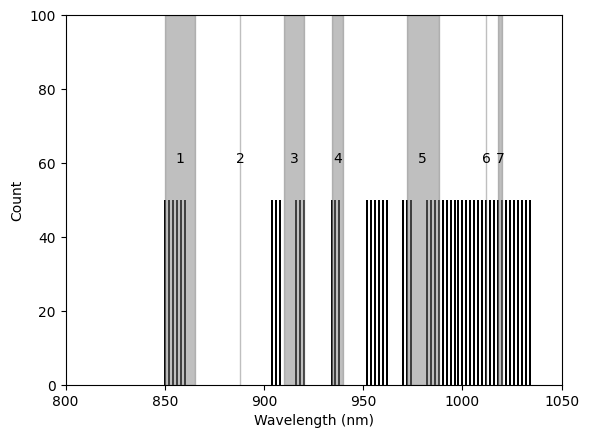

In [ ]:
import matplotlib.pyplot as plt
wavelengths = np.arange(850, 1050 + 1, 2)
selected_wavelengths = 850 + np.array(final_array) * 2

# Count occurrences of selected wavelengths (this could be the frequency or binning logic)
counts, bins = np.histogram(selected_wavelengths, bins=np.arange(850, 1052, 1))
counts *= 50

# Define wavelength intervals for shading
intervals = [(850, 865), (888, 888), (910, 920), (934, 940), (972, 988), (1012, 1012), (1018, 1020)]

plt.bar(bins[:-1], counts, width=(bins[1] - bins[0]), color='black')

# Shading the specific intervals (like in the image)
for i, (start, end) in enumerate(intervals):
    plt.axvspan(start, end, color='gray', alpha=0.5)
    plt.text((start + end) / 2, max(counts) * 1.2, str(i + 1), ha='center')

# Labels and limits
plt.xlabel('Wavelength (nm)')
plt.ylabel('Count')
plt.xlim(800, 1050)
plt.ylim(0, 100)

# Show the plot
plt.show()